In [134]:
pip install pytorch_lightning


In [5]:
from importlib import reload
import utils
reload(utils) 
from utils import *

ModuleNotFoundError: ignored

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image

from utils import *

NameError: ignored

# L63 Data simulation

In [6]:
SD = Simulation_data()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(SD.dt_integration,SD.nb_loop_test*SD.dt_integration+0.000001,SD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=np.arange(0,5+0.000001,SD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[SD.dt_integration,SD.nb_loop_test+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()
  
xt = time_series()
xt.values = S
xt.time   = tt
#Data Extraction
X_train, X_val, X_test, X_train_obs, X_val_obs,X_test_obs, X_train_missing, X_val_missing,X_test_missing, mask_train,mask_val, mask_test,X_train_Init,X_val_Init, X_test_Init, meanTr, stdTr =  L63PatchDataExtraction(xt=xt,RMD=0.5)

meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )

meanTe          = np.mean(X_test_missing[:]) / np.mean(mask_test) 
stdTe           = np.sqrt( np.mean( X_test_missing**2 ) / np.mean(mask_test) )

meanV          = np.mean(X_val_missing[:]) / np.mean(mask_val) 
stdV           = np.sqrt( np.mean( X_val_missing**2 ) / np.mean(mask_val) )

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTe) / stdTe
x_val  = (X_val - meanV) / stdV


x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTe) / stdTe
x_val_obs  = (X_val_obs - meanV) / stdV

x_train_Init = (X_train_Init - meanTr) / stdTr
x_test_Init  = (X_test_Init - meanTe) / stdTe
x_val_Init  = (X_val_Init - meanV) / stdV




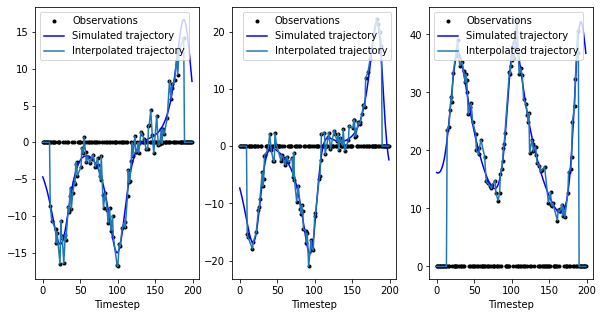

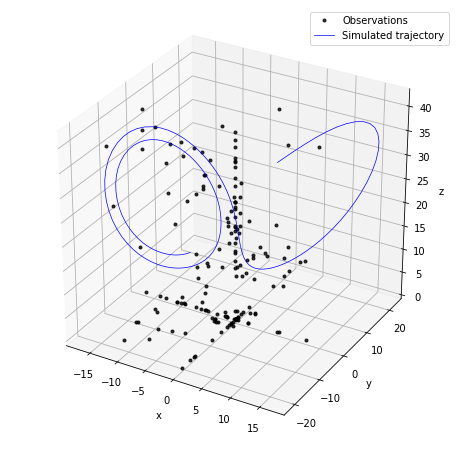

In [52]:
visualisation_data(X_train,X_train_obs,X_train_Init,120)

# Baseline 1 - 4D Var


In [12]:

# define forward model (Euler)
class ODE_L63(pl.LightningModule):
    def __init__(self,sigma,rho,beta):
        super(ODE_L63, self).__init__()
        self.sigma = sigma
        self.rho   = rho
        self.beta  = beta


    def forward(self, x):
      x_1 = (self.sigma*(x[:,1]-x[:,0])).view(-1,1)
      x_2 = (x[:,0]*(self.rho-x[:,2])-x[:,1]).view(-1,1)
      x_3 = (x[:,0]*x[:,1] - self.beta*x[:,2]).view(-1,1)

      return torch.cat((x_1,x_2,x_3),dim=1)
ode_L63 = ODE_L63(10.,28.,8./3)


In [55]:
class model_4DVar(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.t0    = 0
    self.dt    = 0.01
    self.dT    = 200
    self.NIter = 20000
    self.alpha = 0.99
    self.delta = 0.2
    self.automatic_optimization=False
    self.prepare_data_per_node = False
    self._current_fx_name = None
    
    self.tot_loss=[]
    
  def setup(self,stage='None'):
    
    batch_size=1
    training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(X_train_Init),torch.Tensor(X_train_obs),torch.Tensor(mask_train),torch.Tensor(X_train)) 
    self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0)}
    

  def forward(self,x):
    #x_pred   = x[self.t0:self.t0+self.dT-1,:] + self.dt * ode_L63(x[self.t0:self.t0+self.dT-1,:])
    return x
  def training_step(self, train_batch, batch_idx):
    # compute losses
    inputs_init,inputs_missing,masks,targets_GT  = train_batch
    
    X_torch    = torch.Tensor( inputs_init.squeeze().transpose(0,1) )
    XGT_torch  = torch.Tensor( targets_GT.squeeze().transpose(0,1) )
    YObs_torch = torch.Tensor( inputs_missing.squeeze().transpose(0,1) )
    M_torch    = torch.Tensor( masks.squeeze().transpose(0,1) )

    X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

    with torch.set_grad_enabled(True): 
    # dynamical loss
      x_pred   = X_torch[self.t0:self.t0+self.dT-1] + self.dt * ode_L63(X_torch[self.t0:self.t0+self.dT-1])
      loss_dyn = torch.sum((X_torch[self.t0+1:self.t0+self.dT] - x_pred)**2 )

    # observation loss
      loss_obs = torch.sum((X_torch - YObs_torch)**2 * M_torch )

    # overall loss
      loss = (1.-self.alpha) * loss_obs + self.alpha * loss_dyn 

    
    # compute gradient w.r.t. X and update X
      loss.backward()
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
      X_torch = X_torch - self.delta * X_torch.grad.data
      X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

      self.tot_loss.append(loss)
      self.log('train_loss', loss,on_epoch=True)
      self.XGT = XGT_torch[self.t0+1:self.t0+self.dT].detach().numpy()
      self.XHat = x_pred.detach().numpy()
      self.M = M_torch.detach().numpy()
      self.yobs =YObs_torch.detach().numpy()
      return loss

  def visualisation(self):
    plt.figure(figsize = (10,5))
    for kk in range(0,3):
      plt.subplot(1,3,kk+1)
      plt.plot(self.yobs[self.t0:self.t0+self.dT,kk],'.',ms=8,alpha=0.2,label='Observations')
      plt.plot(self.XGT[:,kk],label='Simulated trajectory',alpha=0.8)
      plt.plot(self.XHat[:,kk],label='4DVar Prediction',alpha=0.7)

      plt.title('4DVar Reconstruction')
      plt.legend()
      plt.savefig('4DVar.pdf')

  def reconstruction_score(self):
    varXGT  = np.mean( (self.XGT - np.mean(self.XGT,axis=0))**2 )
    mse_All = np.mean( (self.XHat-self.XGT) **2 ) 
    mse_I   = np.mean( (1.-self.M[self.t0+1:self.t0+self.dT,:]) * (self.XHat-self.XGT) **2 ) / np.mean( (1.-self.M[self.t0:self.t0+self.dT,:]) )
    mse_R   = np.mean( self.M[self.t0+1:self.t0+self.dT,:] * (self.XHat-self.XGT) **2 ) / np.mean( self.M[self.t0:self.t0+self.dT,:] )

    nmse_All = mse_All / varXGT
    nmse_I   = mse_I / varXGT
    nmse_R   = mse_R / varXGT

    print("..... Assimilation performance")
    print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
    print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
    print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))

  def configure_optimizers(self):

      return None
    
  def train_dataloader(self):
      return self.dataloaders['train']
    
  def test_dataloader(self):
      return self.dataloaders['test']


In [ ]:
_4DVar = model_4DVar()
_4DVar.setup()
tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=20000,enable_progress_bar=True,prepare_data_per_node=False,limit_train_batches=1)
trainer.fit(_4DVar)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:74: LightningDeprecationWarning: Setting `prepare_data_per_node` with the trainer flag is deprecated and will be removed in v1.7.0! Please set `prepare_data_per_node` in LightningDataModule or LightningModule directly instead. 
  "Setting `prepare_data_per_node` with the trainer flag is deprecated and will be removed in v1.7.0! "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pyt

Training: 0it [00:00, ?it/s]

In [ ]:
_4DVar.reconstruction_score()
_4DVar.visualisation()

R_score = np.sqrt(((_4DVar.XHat-_4DVar.XGT)**2).mean(axis=1)).mean() 
print('R_score = {}'.format(R_score))

# Baseline 2 : Model CNN



In [7]:
shapeData  = X_train.shape[1:]
dW = 1
dimCNN = 10
class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1  = torch.nn.Conv1d(shapeData[0],shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv2  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv3  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv4  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv5  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv6  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,1,padding=0,bias=False)
        self.conv7  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0],1,padding=0,bias=False)

        self.tot_loss=[]
        self.tot_val_loss=[]
        self.batch_size=128
        self.best_loss=1e10
        
    def forward(self,xinp):
        
        x = self.conv1( xinp )
        x = self.conv2( F.relu(x) )
        x = self.conv3( F.relu(x) )
        #x = self.conv4( F.relu(x) )
        #x = self.conv5( F.relu(x) )
        #x = self.conv6( F.relu(x) )
        x = self.conv7( F.relu(x) )
        x = x.view(-1,shapeData[0],shapeData[1])

        return x
    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(X_train_Init),torch.Tensor(X_train_obs),torch.Tensor(mask_train),torch.Tensor(X_train)) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(X_val_Init),torch.Tensor(X_val_obs),torch.Tensor(mask_val),torch.Tensor(X_val)) 
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(X_test_Init),torch.Tensor(X_test_obs),torch.Tensor(mask_test),torch.Tensor(X_test)) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

        
    def loss(self, x, y):
         return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(epoch_loss)
        
        
        
        self.log('train_loss', epoch_loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs_init,inputs_missing,masks,targets_GT  = val_batch
        running_val_loss = 0.0
        num_val_loss     = 0

        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
           
        running_val_loss             += loss.item() * inputs_missing.size(0)
        num_val_loss                 += inputs_missing.size(0)
        epoch_val_loss       = running_val_loss / num_val_loss
        self.tot_val_loss.append(epoch_val_loss)
        

        
        self.log('val_loss', loss ,prog_bar=False,logger=False)
        if  epoch_val_loss < self.best_loss:
            self.best_loss = epoch_val_loss
            self.best_model_wts = copy.deepcopy(model_CNN.state_dict())

        return loss

    def configure_optimizers(self):
        self.optimizer      = optim.Adam(self.parameters(), lr=1e-2)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

        return self.optimizer
    
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']

In [8]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=20,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv7): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 5760



  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 270   
1 | conv2 | Conv1d | 2.7 K 
2 | conv3 | Conv1d | 2.7 K 
3 | conv7 | Conv1d | 90    
---------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

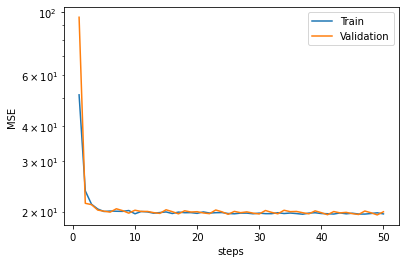

In [242]:
plot_loss(model_CNN,max_epoch=50)

3.9036958


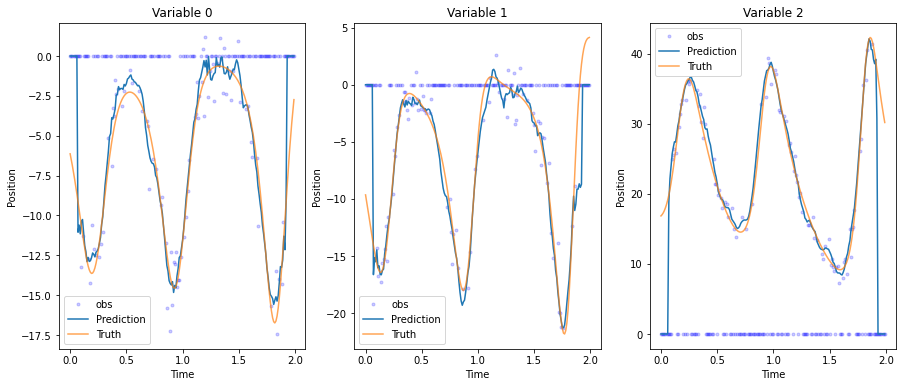

In [10]:
batch_size=128
training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(X_train_Init),torch.Tensor(X_train_obs),torch.Tensor(mask_train),torch.Tensor(X_train)) 
val_dataset      = torch.utils.data.TensorDataset(torch.Tensor(X_val_Init),torch.Tensor(X_val_obs),torch.Tensor(mask_val),torch.Tensor(X_val)) 
test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(X_test_Init),torch.Tensor(X_test_obs),torch.Tensor(mask_test),torch.Tensor(X_test)) 
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset2, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_dataset2, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, num_workers=0)}

plot_prediction(model_CNN,idx=26,dataset = dataloaders['test'])

def R_score(model,idx,dataset): 
    R_score = 0
    test= next(iter(dataset))
    x_truth=test[3][idx].detach().numpy()
    x_pred=model(test[0])
    x_pred=x_pred[idx].detach().numpy()
    R_score = np.sqrt(((x_pred-x_truth)**2).mean(axis=1)).mean()    
    return R_score
r_score = R_score(model_CNN,idx=1,dataset = dataloaders['test'])
print(r_score)